<a href="https://colab.research.google.com/github/OmarAlsaqa/DDS/blob/master/DDS_Image_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning image search

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import preprocess_input
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
# model = VGG16(weights='imagenet', include_top=False)
model = InceptionV3(weights='imagenet', include_top=False)
model.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
______________________

In [0]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

# Caltech 101

http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [0]:
from urllib.request import urlretrieve
import os
import tarfile
import cv2
import pprint
import operator

In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/DDS/Copy of imgs.zip'

In [0]:
!unzip '/content/drive/My Drive/Colab Notebooks/DDS/Copy of driver_imgs_list.csv.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/DDS/Copy of driver_imgs_list.csv.zip
  inflating: driver_imgs_list.csv    


Get the images from folders and lable them

In [0]:
data_directory = "/content" 
categories = os.listdir(data_directory + "/train/")
object_images_count_dict = {}
for category in categories:
    object_images_count_dict[category] = len(os.listdir(data_directory+"/train/"+category))
object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
print(object_images_count_dict)

[('c0', 2489), ('c3', 2346), ('c4', 2326), ('c6', 2325), ('c2', 2317), ('c5', 2312), ('c1', 2267), ('c9', 2129), ('c7', 2002), ('c8', 1911)]


In [0]:
len(object_images_count_dict)

10

In [0]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data not found!")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"train"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # correct colors
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC)
    return img

In [0]:
i = 0
X = np.ndarray((30000, 128, 128, 3), dtype=np.uint8)
Y = []

selected_cls = ['c0', 
                'c1', 
                'c2', 
                'c3', 
                'c4', 
                'c5',
                'c6',
                'c7',
                'c8',
                'c9']

for category,_ in object_images_count_dict:
    if category in selected_cls:
      for image in get_images(category, data_directory):
          if not image.endswith('.jpg'):
              continue
          X[i] = read_image(image)
          Y.insert(i,category) 
          i += 1
      print(str(i+1) + "  " + category)


X = X[:i]
print("Done")


2490  c0
4836  c3
7162  c4
9487  c6
11804  c2
14116  c5
16383  c1
18512  c9
20514  c7
22425  c8
Done


In [0]:
X.shape

(22424, 128, 128, 3)

In [0]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

In [0]:
activity_map[Y[0]]

'Safe driving'

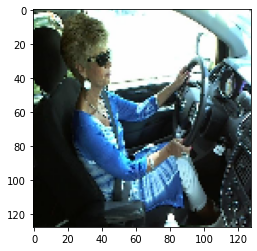

In [0]:
plt.imshow(X[0])

In [0]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([0, 0, 0, ..., 8, 8, 8])

In [0]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [0]:
label_encoder.inverse_transform([np.argmax(Y_one_hot[0])])

array(['c0'], dtype='<U2')

In [0]:
# randomize and select sample data
x_train, x_test, y_train, y_test = train_test_split(X, Y_one_hot, test_size=0.3, random_state=42)

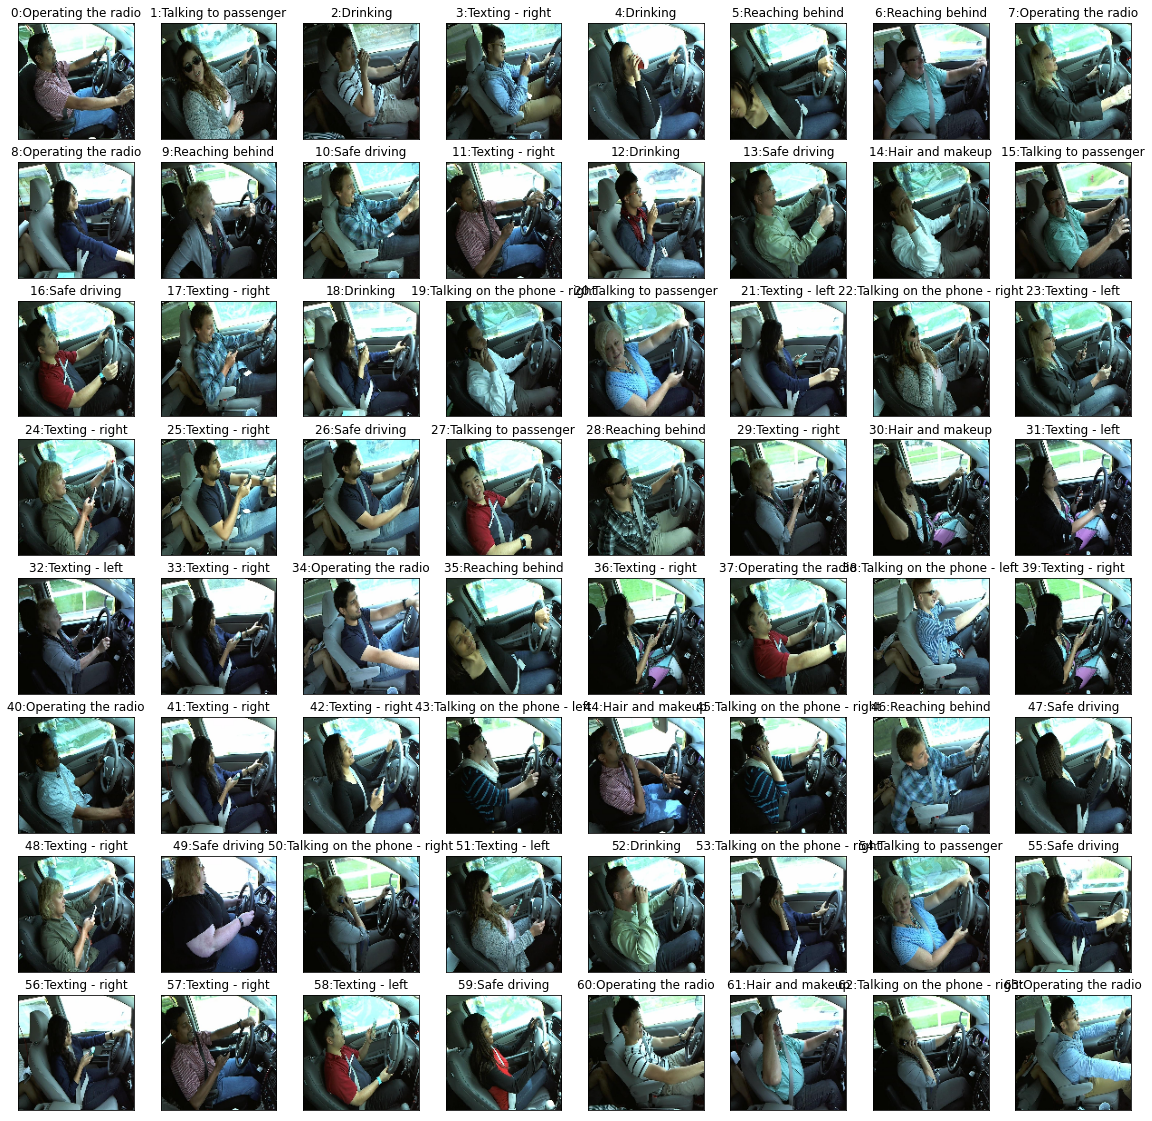

In [0]:
fig=plt.figure(figsize=(20, 20))
columns = 8
rows = 8
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[i])
    t = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
    plt.title(str(i) +":"+ activity_map[t])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
for i in range(len(selected_cls)):
  print(i , activity_map[label_encoder.inverse_transform([i])[0]])

0 Safe driving
1 Texting - right
2 Talking on the phone - right
3 Texting - left
4 Talking on the phone - left
5 Operating the radio
6 Drinking
7 Reaching behind
8 Hair and makeup
9 Talking to passenger


In [0]:
data_set = preprocess_input(x_test)

Predection

In [0]:
feats = model.predict(data_set)
feats = np.squeeze(feats)
print(feats.shape)

(6728, 2, 2, 2048)


# Test Visualization

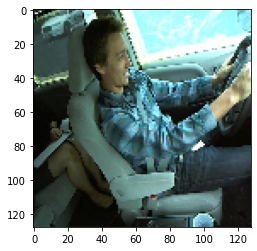

In [0]:
Q_id = 10
Query_image = x_test[Q_id]
plt.imshow(Query_image)
Query_image = preprocess_input(Query_image)
Query_feats = model.predict(np.expand_dims(Query_image, axis=0))
Query_feats = Query_feats.squeeze()

feature based search

In [0]:
# Euclidean distance
results = []
for i in range(feats.shape[0]):
  d = np.linalg.norm(feats[i].flatten() - Query_feats.flatten())
  results.append((d, i))

results = sorted(results)

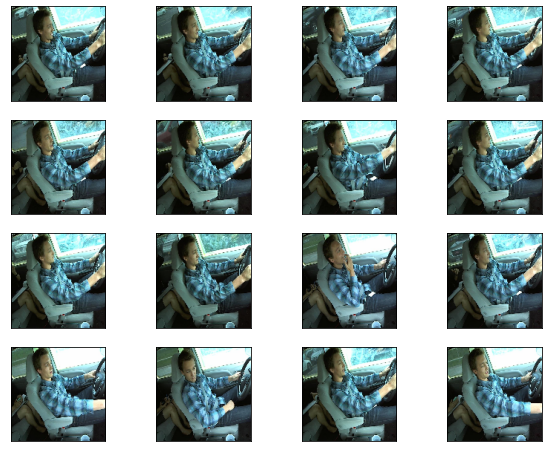

In [0]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

pixel based search

In [0]:
# Euclidean distance
results = []
for i in range(x_test.shape[0]):
  d = np.linalg.norm(x_test[i].flatten() - x_test[Q_id].flatten())
  results.append((d, i))

results = sorted(results)

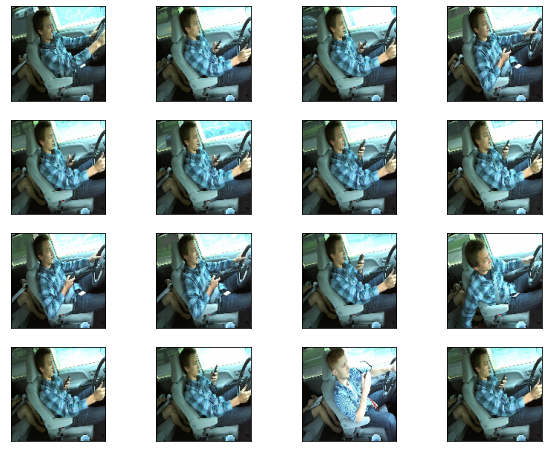

In [0]:
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 4
for i in range(0, columns*rows):
    ax = fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test[results[i][1]])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# t-sne Visualization

In [0]:
# http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
def plot_dataset(X, y, X_embedded, min_dist=10.0):
    fig = plt.figure(figsize=(15, 15))
    ax = plt.axes(frameon=False)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)
    
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y)

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = np.arange(X_embedded.shape[0])
        np.random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            res = cv2.resize(X[i], dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(res), X_embedded[i])
            ax.add_artist(imagebox)

In [0]:
n_tsne = 300

2D Visualization

In [0]:
tsne_feats = np.reshape(feats, (feats.shape[0], feats.shape[1]*feats.shape[2]*feats.shape[3]))[:n_tsne]
tsne_f = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_feats)
print(tsne_f.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.151s...
[t-SNE] Computed neighbors for 300 samples in 1.275s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 41.170123
[t-SNE] Computed conditional probabilities in 0.036s
[t-SNE] Iteration 50: error = 68.1356659, gradient norm = 0.4638923 (50 iterations in 0.111s)
[t-SNE] Iteration 100: error = 67.1734772, gradient norm = 0.5023466 (50 iterations in 0.122s)
[t-SNE] Iteration 150: error = 69.3963776, gradient norm = 0.4810106 (50 iterations in 0.109s)
[t-SNE] Iteration 200: error = 69.9063110, gradient norm = 0.4774567 (50 iterations in 0.117s)
[t-SNE] Iteration 250: error = 69.4208374, gradient norm = 0.4886660 (50 iterations in 0.108s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.420837
[t-SNE] Iteration 300: error = 1.0574296, gradient norm = 0.0088526 (50 iterations in 0.089s)
[t-SNE] Iteration 350: error = 0.8812691, gradient norm = 0.0027007 

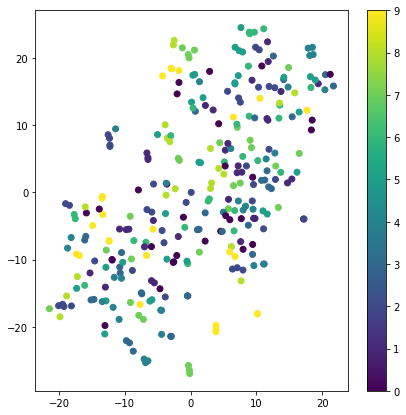

In [0]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_f[:, 0], tsne_f[:, 1], c=c)

plt.colorbar()
plt.show()

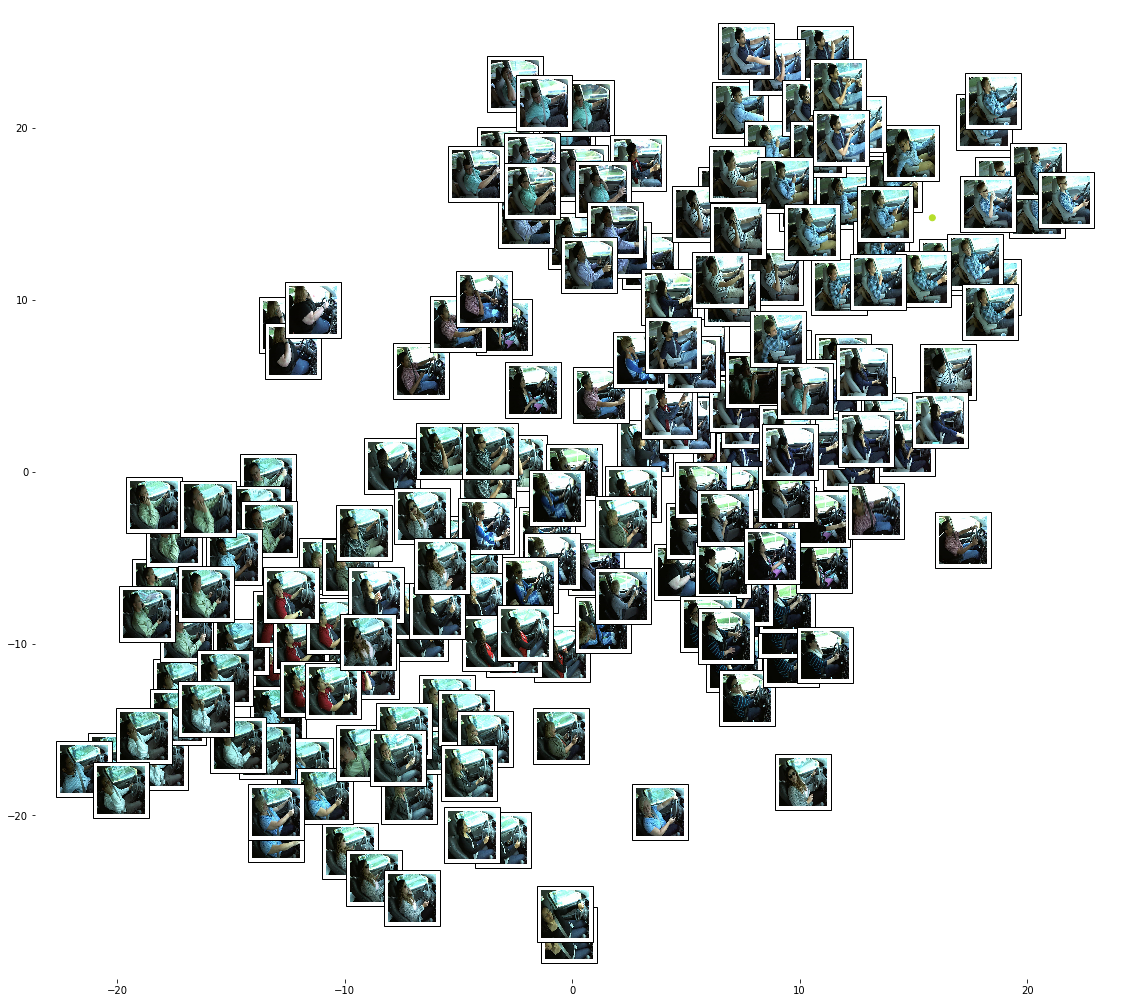

In [0]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_f[:n_tsne], min_dist=1.0)

**1D Visulazation**

In [0]:
tsne_pix = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]))[:n_tsne]
tsne_p = TSNE(n_components=2, perplexity=30, verbose=2).fit_transform(tsne_pix)   
print(tsne_p.shape)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.911s...
[t-SNE] Computed neighbors for 300 samples in 8.801s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 3377.691519
[t-SNE] Computed conditional probabilities in 0.032s
[t-SNE] Iteration 50: error = 57.7779617, gradient norm = 0.5151264 (50 iterations in 0.096s)
[t-SNE] Iteration 100: error = 55.4353867, gradient norm = 0.5215667 (50 iterations in 0.102s)
[t-SNE] Iteration 150: error = 54.5719376, gradient norm = 0.5386656 (50 iterations in 0.093s)
[t-SNE] Iteration 200: error = 55.5807495, gradient norm = 0.5162009 (50 iterations in 0.104s)
[t-SNE] Iteration 250: error = 55.8065033, gradient norm = 0.4941137 (50 iterations in 0.101s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.806503
[t-SNE] Iteration 300: error = 0.2033423, gradient norm = 0.0107460 (50 iterations in 0.091s)
[t-SNE] Iteration 350: error = 0.1761478, gradient norm = 0.009678

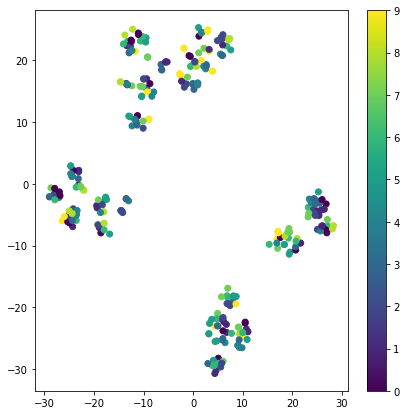

In [0]:
c = np.argmax(y_test[:n_tsne], axis=1)

plt.figure(figsize=(7, 7))
plt.scatter(tsne_p[:, 0], tsne_p[:, 1], c=c)

plt.colorbar()
plt.show()

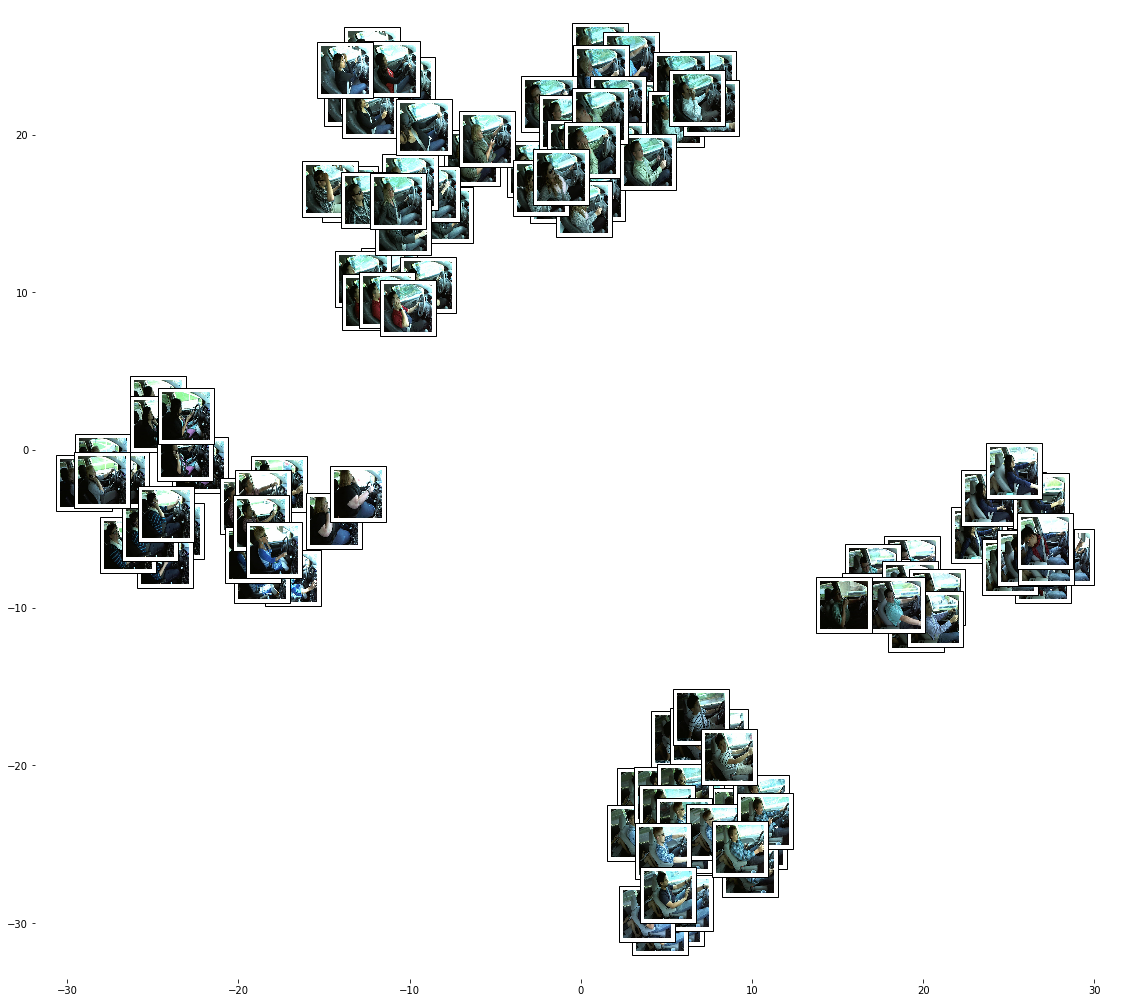

In [0]:
plot_dataset(x_test[:n_tsne], c[:n_tsne], tsne_p[:n_tsne], min_dist=1.0)